## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Normalization


## Load Data

In [2]:
high_altitude = pd.read_csv("./data/measurements-high-altitude.csv")
low_altitude = pd.read_csv("./data/measurements-low-altitude.csv")

## Data cleanup

In [3]:
list(high_altitude)

['hour',
 ' minute',
 ' second',
 ' azimuth angle (relative to west=0)/degree',
 ' elevation angle/degree',
 ' power/mW']

In [4]:
high_altitude.rename(columns={" power/mW" : "power", " azimuth angle (relative to west=0)/degree" : "azimuth", " elevation angle/degree" : "elevation"}, inplace = True)
high_altitude.columns = high_altitude.columns.str.replace(" ", "")

low_altitude.rename(columns={" power/mW" : "power", " azimuth angle (relative to west=0)/degree" : "azimuth", " elevation angle/degree" : "elevation"}, inplace = True)
low_altitude.columns = low_altitude.columns.str.replace(" ", "")

In [5]:
high_altitude.head()

,hour,minute,second,azimuth,elevation,power
0,9,45,5,0,0,32
1,9,45,9,0,15,879
2,9,45,12,0,30,34
3,9,45,15,0,45,35
4,9,45,18,0,60,51


In [6]:
low_altitude.head()

,hour,minute,second,azimuth,elevation,power
0,10,38,3,0,0,56
1,10,38,7,0,15,57
2,10,38,10,0,30,59
3,10,38,14,0,45,57
4,10,38,16,0,60,83


In [7]:
high_altitude.describe()

,hour,minute,second,azimuth,elevation,power
count,2469.000000,2469.000000,2469.000000,2469.000000,2469.000000,2469.000000
mean,11.735925,29.474281,29.589307,89.467801,45.006075,231.443904
std,1.498760,17.265160,17.289971,57.050976,30.037962,175.365305
min,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,11.000000,15.000000,15.000000,36.000000,15.000000,129.000000
50%,12.000000,30.000000,30.000000,90.000000,45.000000,217.000000
75%,13.000000,45.000000,45.000000,144.000000,75.000000,333.000000
max,14.000000,59.000000,59.000000,180.000000,90.000000,4168.000000


In [8]:
high_altitude.loc[high_altitude.power.idxmax(),:]

hour            9
minute         45
second         38
azimuth        18
elevation      45
power        4168
Name: 10, dtype: int64

In [9]:
low_altitude.describe()

,hour,minute,second,azimuth,elevation,power
count,1771.000000,1771.000000,1771.000000,1771.000000,1771.000000,1771.000000
mean,11.880294,30.643139,29.224732,90.000000,45.000000,279.383399
std,1.090955,18.001482,17.335092,56.937075,30.008473,82.632597
min,10.000000,0.000000,0.000000,0.000000,0.000000,41.000000
25%,11.000000,14.000000,14.000000,36.000000,15.000000,225.000000
50%,12.000000,32.000000,29.000000,90.000000,45.000000,302.000000
75%,13.000000,47.000000,44.000000,144.000000,75.000000,352.000000
max,14.000000,59.000000,59.000000,180.000000,90.000000,378.000000


### Convert time in seconds

In [11]:
def get_seconds(h, m, s):
  s_vec = []
  for i in range(len(s)):
    s_vec.append(h[i]*3600 + m[i]*60 + s[i])
  return s_vec

In [12]:
h, m, s = low_altitude.hour.tolist(), low_altitude.minute.tolist(), low_altitude.second.tolist()
seconds = get_seconds(h,m,s)
low_altitude.drop(columns=["hour", "minute", "second"], inplace=True)
low_altitude["seconds"] = seconds

In [13]:
h, m, s = high_altitude.hour.tolist(), high_altitude.minute.tolist(), high_altitude.second.tolist()
seconds = get_seconds(h,m,s)
high_altitude.drop(columns=["hour", "minute", "second"], inplace=True)
high_altitude["seconds"] = seconds

### Removing outliers from high_altitude

In [14]:
high_altitude.shape


(2469, 4)

In [15]:
high_altitude = high_altitude[(np.abs(stats.zscore(high_altitude)) < 3).all(axis=1)]

In [16]:
high_altitude.shape

(2459, 4)

### Plots

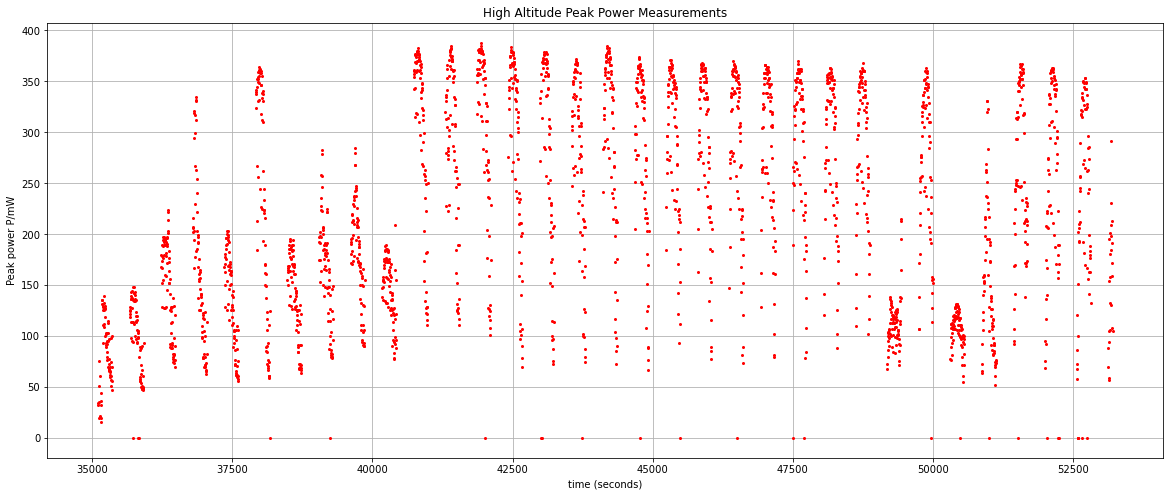

In [17]:
plt.figure(figsize=(20,8))
plt.plot(high_altitude.seconds, high_altitude.power, 'or', markersize=2)
plt.title("High Altitude Peak Power Measurements")
plt.xlabel("time (seconds)")
plt.ylabel("Peak power P/mW")
plt.grid()

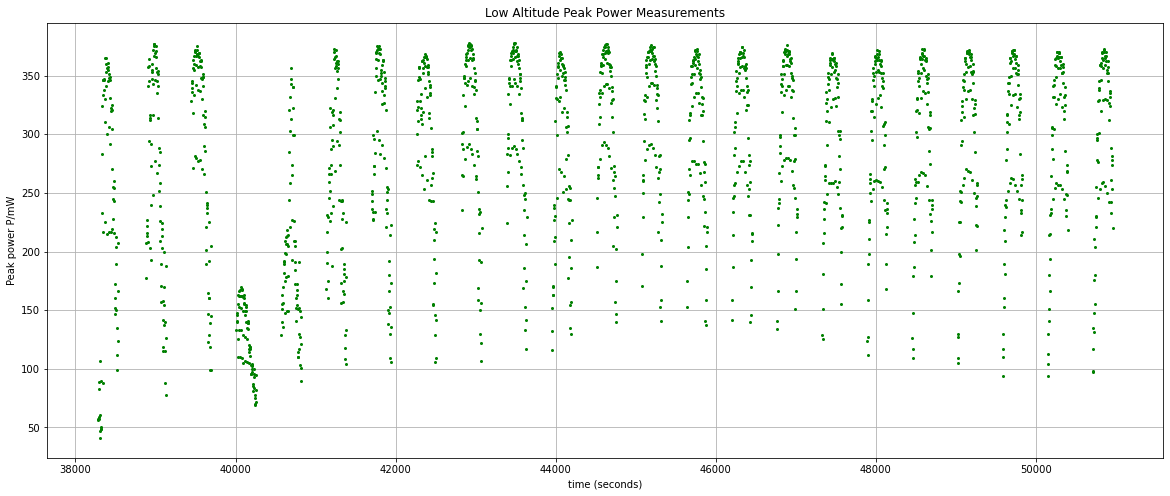

In [18]:
plt.figure(figsize=(20,8))
plt.plot(low_altitude.seconds, low_altitude.power, 'og', markersize=2)
plt.title("Low Altitude Peak Power Measurements")
plt.xlabel("time (seconds)")
plt.ylabel("Peak power P/mW")
plt.grid()

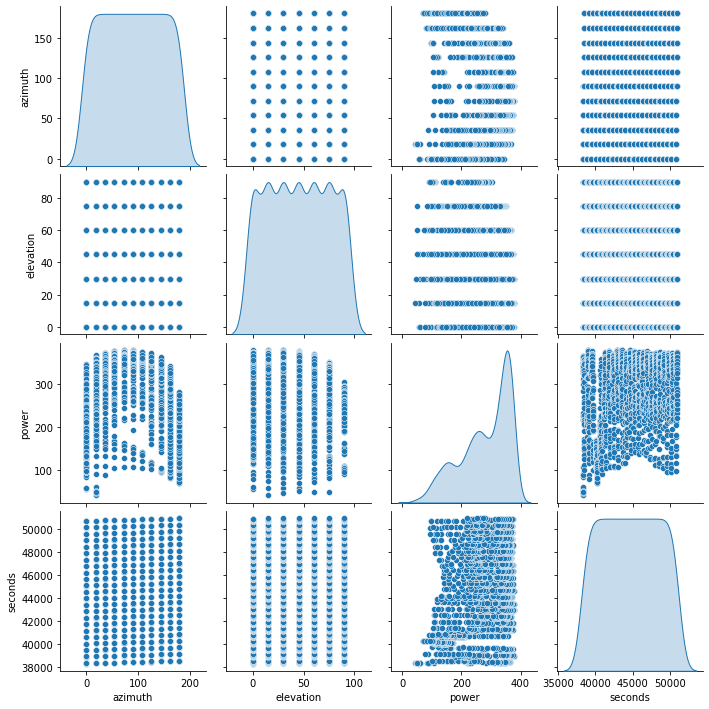

In [19]:
sns.pairplot(low_altitude, diag_kind='kde')

## Train test split

In [20]:
X_low_train = low_altitude.sample(frac=0.8, random_state=2)
X_low_test = low_altitude.drop(X_low_train.index)

y_low_train = X_low_train.pop("power")
y_low_test = X_low_test.pop("power")

In [21]:
X_high_train = high_altitude.sample(frac=0.8, random_state=2)
X_high_test = high_altitude.drop(X_high_train.index)

y_high_train = X_high_train.pop("power")
y_high_test = X_high_test.pop("power")

In [22]:
y_low_train.describe()

count    1417.000000
mean      279.540579
std        82.386542
min        49.000000
25%       227.000000
50%       301.000000
75%       351.000000
max       378.000000
Name: power, dtype: float64

In [23]:
y_high_train.describe()

count    1967.000000
mean      224.564311
std       104.227067
min         0.000000
25%       129.000000
50%       216.000000
75%       333.000000
max       388.000000
Name: power, dtype: float64

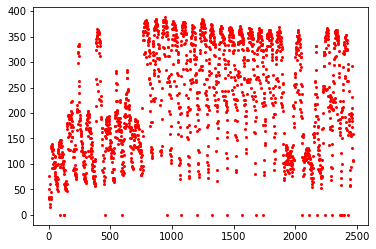

In [44]:
plt.plot(y_high_train, 'or', markersize=2)

In [25]:
normalizer_low = Normalization(axis=-1)
normalizer_low.adapt(np.array(X_low_train))

print(normalizer_low.mean.numpy())

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-06-24 17:49:09.138218: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-24 17:49:09.138560: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2022-06-24 17:49:09.184064: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-24 17:49:09.249205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-24 17:49:09.262254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[   88.81864     45.719826 44603.668   ]]


In [26]:
first_sample = np.array(X_low_train[:1])

with np.printoptions(precision=2, suppress=True):
  print(np.sort(first_sample))
  print(np.sort(normalizer_low(first_sample).numpy()))


[[    0    15 42266]]
[[-1.56 -1.02 -0.62]]


# Baseline Dataset

## Regression using MLP

In [27]:
def create_regressor(normalizer):
  reg = Sequential([
  normalizer,
  Dense(units=256, activation='relu'),
  Dropout(0.3),
  Dense(units=128, activation='relu'),
  Dense(units=1)
])

  return reg

In [28]:
callbacks=[tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-10, verbose=1), tf.keras.callbacks.EarlyStopping(patience=30)]

In [29]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

### Regression on Low Altitude

In [30]:
reg_low = create_regressor(normalizer_low)
reg_low.predict(X_low_train[:10])

2022-06-24 17:49:09.754608: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[-0.22521076],
       [-0.07482108],
       [-0.10971706],
       [-0.052421  ],
       [-0.12102143],
       [-0.08103396],
       [-0.09218245],
       [-0.08985657],
       [-0.1584856 ],
       [-0.03225846]], dtype=float32)

In [31]:
reg_low.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 3)                7         
 n)                                                              
                                                                 
 dense (Dense)               (None, 256)               1024      
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34,056
Trainable params: 34,049
Non-trainable params: 7
____________________________________________________

In [32]:
reg_low.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss="mae")

In [33]:
history = reg_low.fit(X_low_train, y_low_train, epochs=1000, validation_split=0.2, callbacks=callbacks)

Epoch 1/1000
11/36 [========>.....................] - ETA: 0s - loss: 137.1253

2022-06-24 17:49:10.006010: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 1s 9ms/step - loss: 100.6656 - val_loss: 56.3914 - lr: 0.1000
Epoch 2/1000
22/36 [=================>............] - ETA: 0s - loss: 58.1786

2022-06-24 17:49:10.380030: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


36/36 [==============================] - 0s 6ms/step - loss: 63.0105 - val_loss: 53.4438 - lr: 0.1000
Epoch 3/1000
36/36 [==============================] - 0s 6ms/step - loss: 48.5251 - val_loss: 71.4510 - lr: 0.1000
Epoch 4/1000
36/36 [==============================] - 0s 6ms/step - loss: 49.3752 - val_loss: 36.6847 - lr: 0.1000
Epoch 5/1000
36/36 [==============================] - 0s 6ms/step - loss: 41.3649 - val_loss: 33.0871 - lr: 0.1000
Epoch 6/1000
36/36 [==============================] - 0s 6ms/step - loss: 44.8263 - val_loss: 66.4452 - lr: 0.1000
Epoch 7/1000
36/36 [==============================] - 0s 6ms/step - loss: 44.4634 - val_loss: 34.0672 - lr: 0.1000
Epoch 8/1000
36/36 [==============================] - 0s 6ms/step - loss: 36.7042 - val_loss: 28.2825 - lr: 0.1000
Epoch 9/1000
36/36 [==============================] - 0s 6ms/step - loss: 36.6380 - val_loss: 29.5876 - lr: 0.1000
Epoch 10/1000
36/36 [==============================] - 0s 6ms/step - loss: 49.7333 - val_loss

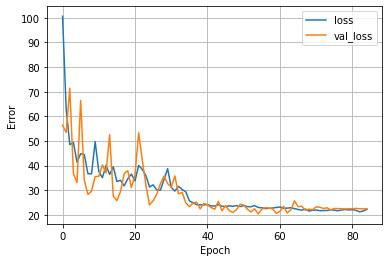

In [34]:
plot_loss(history)

In [35]:
results = reg_low.evaluate(X_low_test, y_low_test)

12/12 [==============================] - 0s 7ms/step - loss: 23.5376


### Regression on High Altitude

In [36]:
normalizer_high = Normalization(axis=-1)
normalizer_high.adapt(np.array(X_high_train))

print(normalizer_high.mean.numpy())

2022-06-24 17:49:31.314799: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-24 17:49:31.326693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


[[   89.49671     45.289783 44092.188   ]]


In [37]:
first_sample = np.array(X_high_train[:1])

with np.printoptions(precision=2, suppress=True):
  print(np.sort(first_sample))
  print(np.sort(normalizer_high(first_sample).numpy()))

[[   15   144 42050]]
[[-1.01 -0.39  0.96]]


In [38]:
reg_high = create_regressor(normalizer_high)
reg_high.predict(X_high_train[:10])

2022-06-24 17:49:31.930455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[-0.05764356],
       [-0.26270354],
       [-0.05209596],
       [-0.01910476],
       [-0.07781573],
       [-0.3537997 ],
       [-0.03887184],
       [-0.12449349],
       [-0.23954406],
       [ 0.01150942]], dtype=float32)

In [39]:
reg_high.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 3)                7         
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 256)               1024      
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 34,056
Trainable params: 34,049
Non-trainable params: 7
__________________________________________________

In [40]:
reg_high.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mae')

In [41]:
history = reg_high.fit(X_high_train, y_high_train, epochs=1000, validation_split=0.2, callbacks=callbacks)

Epoch 1/1000
10/50 [=====>........................] - ETA: 0s - loss: 135.4552 

2022-06-24 17:49:32.195096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 13ms/step - loss: 91.6031 - val_loss: 188.3108 - lr: 0.1000
Epoch 2/1000
 8/50 [===>..........................] - ETA: 0s - loss: 124.5320

2022-06-24 17:49:32.843817: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 0s 7ms/step - loss: 81.2936 - val_loss: 55.2702 - lr: 0.1000
Epoch 3/1000
50/50 [==============================] - 0s 8ms/step - loss: 56.5710 - val_loss: 55.2520 - lr: 0.1000
Epoch 4/1000
50/50 [==============================] - 0s 7ms/step - loss: 56.8989 - val_loss: 57.8799 - lr: 0.1000
Epoch 5/1000
50/50 [==============================] - 0s 7ms/step - loss: 54.1012 - val_loss: 64.8830 - lr: 0.1000
Epoch 6/1000
50/50 [==============================] - 0s 6ms/step - loss: 50.8850 - val_loss: 44.4427 - lr: 0.1000
Epoch 7/1000
50/50 [==============================] - 0s 6ms/step - loss: 49.6877 - val_loss: 52.0667 - lr: 0.1000
Epoch 8/1000
50/50 [==============================] - 0s 7ms/step - loss: 50.9253 - val_loss: 53.6014 - lr: 0.1000
Epoch 9/1000
50/50 [==============================] - 0s 6ms/step - loss: 51.6563 - val_loss: 43.5539 - lr: 0.1000
Epoch 10/1000
50/50 [==============================] - 0s 6ms/step - loss: 47.9923 - val_loss

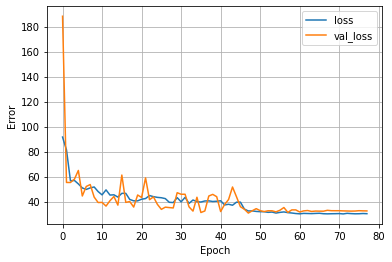

In [42]:
plot_loss(history)

In [43]:
results = reg_high.evaluate(X_high_test, y_high_test)

16/16 [==============================] - 0s 4ms/step - loss: 37.7464
